In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from random import sample
from sklearn.model_selection import train_test_split
import torch.optim as optim

from torch.utils.data import DataLoader

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

Upload the labels.csv and processed_counts.csv files to colab or your local workspace.

This data associates a cell barcode, such as "AAAGCCTGGCTAAC-1", to a certain cell type label, such as "CD14+ Monocyte". For each cell barcode, there are also log RNA seq counts of 765 different genes, such as HES4.

label.csv stores the association between a cell barcode and a cell type label.

processed_counts.csv stores the normalized log read counts for each cell, where each row represents a single cell, and each column represents a gene.

## Data Pre-processing

In [5]:
labels_pd = pd.read_csv("/content/drive/My Drive/245/final project/labels.csv")
counts_pd = pd.read_csv("/content/drive/My Drive/245/final project/processed_counts.csv")

In [6]:
display(labels_pd, counts_pd)

index      bulk_labels
0    AAAGCCTGGCTAAC-1   CD14+ Monocyte
1    AAATTCGATGCACA-1        Dendritic
2    AACACGTGGTCTTT-1         CD56+ NK
3    AAGTGCACGTGCTA-1  CD4+/CD25 T Reg
4    ACACGAACGGAGTG-1        Dendritic
..                ...              ...
695  TGGCACCTCCAACA-8        Dendritic
696  TGTGAGTGCTTTAC-8        Dendritic
697  TGTTACTGGCGATT-8  CD4+/CD25 T Reg
698  TTCAGTACCGGGAA-8          CD19+ B
699  TTGAGGTGGAGAGC-8        Dendritic

[700 rows x 2 columns]

Unnamed: 0   HES4  TNFRSF4  SSU72  PARK7   RBP7    SRM  MAD2L2  \
0    AAAGCCTGGCTAAC-1 -0.326   -0.191 -0.728 -0.301  3.386 -0.531   2.016   
1    AAATTCGATGCACA-1  1.171   -0.191  0.795 -1.200 -0.174 -0.531   1.889   
2    AACACGTGGTCTTT-1 -0.326   -0.191  0.483 -1.200 -0.174 -0.531  -0.451   
3    AAGTGCACGTGCTA-1 -0.326   -0.191  1.134 -0.157 -0.174 -0.531  -0.451   
4    ACACGAACGGAGTG-1 -0.326   -0.191 -0.728 -0.607 -0.174 -0.531  -0.451   
..                ...    ...      ...    ...    ...    ...    ...     ...   
695  TGGCACCTCCAACA-8 -0.326   -0.191  0.372 -0.584 -0.174  0.509  -0.451   
696  TGTGAGTGCTTTAC-8  3.166   -0.191 -0.728 -1.200 -0.174 -0.531  -0.451   
697  TGTTACTGGCGATT-8 -0.326   -0.191 -0.728 -1.200 -0.174  1.784  -0.451   
698  TTCAGTACCGGGAA-8 -0.326   -0.191 -0.728 -0.386 -0.174 -0.531  -0.451   
699  TTGAGGTGGAGAGC-8 -0.326   -0.191  0.148  0.762 -0.174  0.298  -0.451   

     AGTRAP  TNFRSF1B  ...  ATP5O  MRPS6   TTC3  U2AF1   CSTB  SUMO3  ITGB2  \
0     3.377     4.841  ... -0.146 -0.532 -0.341  0.303  1.404  4.294  0.519   
1    -0.486    -0.459  ... -1.136 -0.532 -0.341 -0.905  2.849 -0.585  1.172   
2     0.971    -0.459  ... -1.136  2.606 -0.341 -0.905 -0.455 -0.585  0.722   
3    -0.486    -0.459  ...  1.161 -0.532 -0.341 -0.905 -0.119 -0.585  0.766   
4     0.787    -0.459  ... -1.136  0.839  1.679 -0.108 -0.534 -0.585 -0.007   
..      ...       ...  ...    ...    ...    ...    ...    ...    ...    ...   
695   2.160    -0.459  ...  1.576 -0.532  1.758  1.578  0.055 -0.585  0.561   
696  -0.486    -0.459  ... -1.136 -0.532 -0.341  0.432  0.753 -0.585 -0.171   
697  -0.486    -0.459  ... -0.381 -0.532 -0.341  1.858  0.814 -0.585  0.152   
698  -0.486    -0.459  ... -1.136 -0.532 -0.341  2.378  0.420  0.888 -0.326   
699  -0.486     0.505  ... -1.136 -0.532 -0.341  1.073 -0.628 -0.585  0.239   

     S100B  PRMT2  MT-ND3  
0    -0.21 -0.636   4.011  
1    -0.21  2.630  -0.490  
2    -0.21  0.663  -0.490  
3    -0.21 -0.636  -0.490  
4    -0.21 -0.636  -0.490  
..     ...    ...     ...  
695  -0.21  0.543   2.593  
696  -0.21  1.268  -0.490  
697  -0.21 -0.636   1.226  
698  -0.21 -0.636  -0.490  
699  -0.21 -0.636  -0.490  

[700 rows x 766 columns]

Shuffle your data. Make sure your labels and the counts are shuffled together.

Split into train and test sets (80:20 split)

In [7]:
labels_pd.index = labels_pd['index']
labels_pd.drop("index", axis=1, inplace=True)
counts_pd.index = counts_pd['Unnamed: 0']
counts_pd.drop("Unnamed: 0", axis=1, inplace=True)

df = counts_pd.merge(labels_pd, left_index=True, right_index=True).dropna()
df

HES4  TNFRSF4  SSU72  PARK7   RBP7    SRM  MAD2L2  AGTRAP  \
AAAGCCTGGCTAAC-1 -0.326   -0.191 -0.728 -0.301  3.386 -0.531   2.016   3.377   
AAATTCGATGCACA-1  1.171   -0.191  0.795 -1.200 -0.174 -0.531   1.889  -0.486   
AACACGTGGTCTTT-1 -0.326   -0.191  0.483 -1.200 -0.174 -0.531  -0.451   0.971   
AAGTGCACGTGCTA-1 -0.326   -0.191  1.134 -0.157 -0.174 -0.531  -0.451  -0.486   
ACACGAACGGAGTG-1 -0.326   -0.191 -0.728 -0.607 -0.174 -0.531  -0.451   0.787   
...                 ...      ...    ...    ...    ...    ...     ...     ...   
TGGCACCTCCAACA-8 -0.326   -0.191  0.372 -0.584 -0.174  0.509  -0.451   2.160   
TGTGAGTGCTTTAC-8  3.166   -0.191 -0.728 -1.200 -0.174 -0.531  -0.451  -0.486   
TGTTACTGGCGATT-8 -0.326   -0.191 -0.728 -1.200 -0.174  1.784  -0.451  -0.486   
TTCAGTACCGGGAA-8 -0.326   -0.191 -0.728 -0.386 -0.174 -0.531  -0.451  -0.486   
TTGAGGTGGAGAGC-8 -0.326   -0.191  0.148  0.762 -0.174  0.298  -0.451  -0.486   

                  TNFRSF1B  EFHD2  ...  MRPS6   TTC3  U2AF1   CSTB  SUMO3  \
AAAGCCTGGCTAAC-1     4.841 -0.525  ... -0.532 -0.341  0.303  1.404  4.294   
AAATTCGATGCACA-1    -0.459 -0.525  ... -0.532 -0.341 -0.905  2.849 -0.585   
AACACGTGGTCTTT-1    -0.459  2.286  ...  2.606 -0.341 -0.905 -0.455 -0.585   
AAGTGCACGTGCTA-1    -0.459 -0.525  ... -0.532 -0.341 -0.905 -0.119 -0.585   
ACACGAACGGAGTG-1    -0.459  1.932  ...  0.839  1.679 -0.108 -0.534 -0.585   
...                    ...    ...  ...    ...    ...    ...    ...    ...   
TGGCACCTCCAACA-8    -0.459  0.751  ... -0.532  1.758  1.578  0.055 -0.585   
TGTGAGTGCTTTAC-8    -0.459  1.536  ... -0.532 -0.341  0.432  0.753 -0.585   
TGTTACTGGCGATT-8    -0.459 -0.525  ... -0.532 -0.341  1.858  0.814 -0.585   
TTCAGTACCGGGAA-8    -0.459 -0.525  ... -0.532 -0.341  2.378  0.420  0.888   
TTGAGGTGGAGAGC-8     0.505 -0.525  ... -0.532 -0.341  1.073 -0.628 -0.585   

                  ITGB2  S100B  PRMT2  MT-ND3      bulk_labels  
AAAGCCTGGCTAAC-1  0.519  -0.21 -0.636   4.011   CD14+ Monocyte  
AAATTCGATGCACA-1  1.172  -0.21  2.630  -0.490        Dendritic  
AACACGTGGTCTTT-1  0.722  -0.21  0.663  -0.490         CD56+ NK  
AAGTGCACGTGCTA-1  0.766  -0.21 -0.636  -0.490  CD4+/CD25 T Reg  
ACACGAACGGAGTG-1 -0.007  -0.21 -0.636  -0.490        Dendritic  
...                 ...    ...    ...     ...              ...  
TGGCACCTCCAACA-8  0.561  -0.21  0.543   2.593        Dendritic  
TGTGAGTGCTTTAC-8 -0.171  -0.21  1.268  -0.490        Dendritic  
TGTTACTGGCGATT-8  0.152  -0.21 -0.636   1.226  CD4+/CD25 T Reg  
TTCAGTACCGGGAA-8 -0.326  -0.21 -0.636  -0.490          CD19+ B  
TTGAGGTGGAGAGC-8  0.239  -0.21 -0.636  -0.490        Dendritic  

[700 rows x 766 columns]

In [8]:
y = df['bulk_labels']

#remove label when processing input data
X = df.drop('bulk_labels', axis=1).values

#shufle and 80:20 split
np.random.seed(100)
permutation = np.random.permutation(len(X))
X, y = X[permutation], y[permutation]

X_train, y_train = X[:int(len(X)*0.8)], y[:int(len(y)*0.8)]
X_test, y_test = X[int(len(X)*0.8):], y[int(len(y)*0.8):]

In [9]:
display(X, y)

array([[-0.326, -0.191, -0.728, ..., -0.21 , -0.636, -0.49 ],
       [-0.326, -0.191, -0.728, ..., -0.21 ,  2.134, -0.49 ],
       [-0.326, -0.191,  0.32 , ..., -0.21 , -0.636, -0.49 ],
       ...,
       [-0.326, -0.191,  1.898, ..., -0.21 ,  2.18 , -0.49 ],
       [ 3.848, -0.191, -0.728, ..., -0.21 , -0.636, -0.49 ],
       [-0.326,  2.487,  0.497, ..., -0.21 , -0.636, -0.49 ]])

CACTTTGACTCAAG-5                CD8+ Cytotoxic T
GGACTATGCTCTAT-4    CD8+/CD45RA+ Naive Cytotoxic
GCCAACCTGTAGGG-3                       Dendritic
TATGTCTGTTCCCG-5                           CD34+
CTACTATGGGCGAA-5                        CD56+ NK
                                ...             
GCACGGACTTGCAG-7                CD8+ Cytotoxic T
GCAATTCTGACGAG-1                       Dendritic
AAATTCGAAGTCTG-5                         CD19+ B
TACTCTGACGTAGT-1                       Dendritic
AACCACGAGGTTAC-7                         CD19+ B
Name: bulk_labels, Length: 700, dtype: object

Create a fully connected neural network for your autoencoder. Your latent space can be of any size less than or equal to 64. Too large may result in a poor visualization, and too small may result in high loss. 32 is a good starting point.

Consider using more than 1 hidden layer, and a sparcity constraint (l1 regularization).

Have an encoder model which is a model of only the layers for the encoding.

## nn.Module

In [10]:
# build the autoencoder model

# 765 is the feature of X data (both train and test)
input_shape = (765, )
# define the feature number of latent space
latent_dim = 48
dropout_rate = 0.2

# construct autoencoder with L1 regularization
class autoencoderl1(nn.Module):
    def __init__(self):
        super(autoencoderl1, self).__init__()
        
    #Encoder NN
        self.encoder = nn.Sequential(
            nn.Linear(input_shape[0], 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.Linear(64, latent_dim),
        )
    
    #Decoder NN
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.Dropout(dropout_rate),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512, input_shape[0]),
            nn.Sigmoid()
        )
    
    #L1 regularization
        self.reg = nn.L1Loss(reduction='sum')
    
    def forward(self, X):
        #X = torch.from_numpy(X)
        X = torch.clone(X)
        #X = X.float()
        X = self.encoder(X)
        X = self.decoder(X)
        return X

## Autoencoder

Train your autoencoding using MSE loss.

Finally, identify the parameters which don't overfit, and use the same model architecture and train on all of the data together.

With a latent space size of 32, aim for 0.9 MSE loss on your test set, 0.95 with regularization. You will not be graded strictly on a loss cutoff.

In [11]:
from sklearn.metrics import accuracy_score
from copy import deepcopy

# define train model
def train(model, X_train, X_test, batch_size=16, epochs = 15, lr=1e-4, l1_lambda = 1e-7):
    
    train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=False)
    #testing_loader = DataLoader(X_test, batch_size=batch_size, shuffle=False)
    best_mse = 100
    best_model = None
    
    loss_mse = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    test_losses = []
    #accuracies = []
    
    for epoch in range(epochs):
        #X_train only has X but not y and loaded in train_loader
        loss = 0
        l1_loss = 0
        for data in iter(train_loader):
            data = data.float()
            
            logits = model.forward(data)
            #print(logits.dtype)
            loss = loss_mse(logits, data)

            # this is for L1 regulate hyperparameters
            # for param in model.parameters():
            #     param.data = param.data.float()

            #     #l1_reg += torch.norm(param, 1)  # In PyTorch, torch.norm(param, 2) computes the L2-norm of the tensor param.
            
            #This is for L1 regulate latent space
            l1_regularization = l1_lambda * torch.mean(torch.abs(logits)) 
            l1_loss += l1_regularization
            loss += l1_regularization
            
            loss = loss.float()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        #calcualte train loss after optimization
        # train_loss = loss
        # train_losses.append(float(train_loss))
        # l1_loss = loss/len(train_loader)

        X_train = torch.tensor(X_train).float()
        train_label = model.forward(X_train)
        train_loss = loss_mse(train_label, X_train)
        # l1_reg = 0
        # for param in model.parameters():
        #     param.data = param.data.float()
        #     l1_reg += torch.norm(param, 1)  # In PyTorch, torch.norm(param, 2) computes the L2-norm of the tensor param
        # train_loss += l1_lambda * l1_reg
        train_losses.append(train_loss.detach().numpy())
        
        #calcualte test loss
        X_test = torch.tensor(X_test).float()

        #print(X_test)
        testing_latent = model.forward(X_test)
        #print(testing_label, y_test)
        test_loss = loss_mse(testing_latent, X_test)
        # l1_loss_test = l1_lambda*torch.mean(torch.abs(testing_latent)) 
        # test_loss += l1_loss_test
        test_losses.append(test_loss.detach().numpy())

        if test_loss < best_mse:
            best_mse = test_loss
            best_model = deepcopy(model)
        if test_loss > best_mse+0.1:
            print("stop early!")
            break
        
        print(f"Epoch {epoch + 1}:\ttrain loss {train_loss}")
        print("train loss from l1:", l1_loss)
        print(f"Epoch {epoch + 1}:\ttest loss {test_loss}")
       
    print(f"Resetting model... Smallest test loss:\t{best_mse}")
    model.load_state_dict(best_model.state_dict())
    torch.save({'model_state_dict_0420': best_model.state_dict(),
                'optimizer_state_dict_0420': optimizer.state_dict()},
                'autoencoder_model_0420.pth')
    return train_losses, test_losses
            

### Train autoencoder on training dataset and obtain accuracy on testing dataset

In [12]:
model = autoencoderl1()
train_losses, test_losses = train(model, X_train, X_test, lr=1e-4, l1_lambda = 1e-4, batch_size=16, epochs=30)

Epoch 1:	train loss 1.165374994277954
train loss from l1: tensor(0.0015, grad_fn=<AddBackward0>)
Epoch 1:	test loss 1.149019718170166


<ipython-input-11-404dd392b6a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train).float()
<ipython-input-11-404dd392b6a4>:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test).float()


Epoch 2:	train loss 1.101991891860962
train loss from l1: tensor(0.0012, grad_fn=<AddBackward0>)
Epoch 2:	test loss 1.085575819015503
Epoch 3:	train loss 1.0639058351516724
train loss from l1: tensor(0.0009, grad_fn=<AddBackward0>)
Epoch 3:	test loss 1.0505266189575195
Epoch 4:	train loss 1.0460536479949951
train loss from l1: tensor(0.0007, grad_fn=<AddBackward0>)
Epoch 4:	test loss 1.0324288606643677
Epoch 5:	train loss 1.03304123878479
train loss from l1: tensor(0.0006, grad_fn=<AddBackward0>)
Epoch 5:	test loss 1.0225489139556885
Epoch 6:	train loss 1.0262515544891357
train loss from l1: tensor(0.0005, grad_fn=<AddBackward0>)
Epoch 6:	test loss 1.0155065059661865
Epoch 7:	train loss 1.0214638710021973
train loss from l1: tensor(0.0004, grad_fn=<AddBackward0>)
Epoch 7:	test loss 1.0118552446365356
Epoch 8:	train loss 1.0177680253982544
train loss from l1: tensor(0.0004, grad_fn=<AddBackward0>)
Epoch 8:	test loss 1.0090744495391846
Epoch 9:	train loss 1.0148566961288452
train loss fr

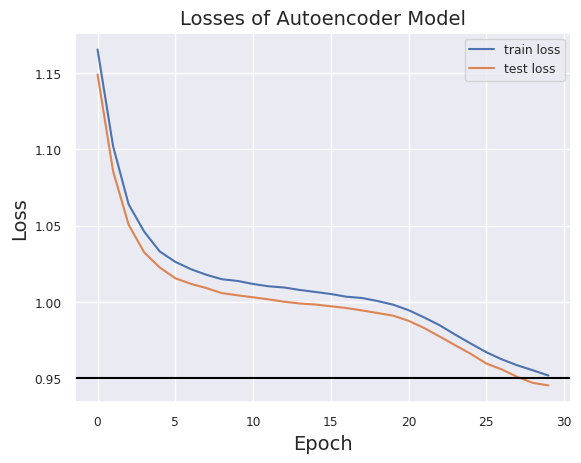

In [24]:

plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title("Losses of Autoencoder Model", fontsize=14)
plt.axhline(y = 0.95, color='black')
plt.legend();

### Obtain the model of autoencoder based on the whole dataset via the same autoencoder architecture

In [32]:
# use the same architecture to train all data
model_all = autoencoderl1()
train_losses_all, test_losses_all = train(model_all, X, X_test, lr=1e-4, l1_lambda = 1e-4, batch_size=16, epochs=30)

Epoch 1:	train loss 1.1428942680358887
train loss from l1: tensor(0.0019, grad_fn=<AddBackward0>)
Epoch 1:	test loss 1.130235195159912


<ipython-input-11-404dd392b6a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train).float()
<ipython-input-11-404dd392b6a4>:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test).float()


Epoch 2:	train loss 1.0788387060165405
train loss from l1: tensor(0.0013, grad_fn=<AddBackward0>)
Epoch 2:	test loss 1.0646328926086426
Epoch 3:	train loss 1.0462850332260132
train loss from l1: tensor(0.0010, grad_fn=<AddBackward0>)
Epoch 3:	test loss 1.0344144105911255
Epoch 4:	train loss 1.0314983129501343
train loss from l1: tensor(0.0007, grad_fn=<AddBackward0>)
Epoch 4:	test loss 1.020289659500122
Epoch 5:	train loss 1.0233749151229858
train loss from l1: tensor(0.0006, grad_fn=<AddBackward0>)
Epoch 5:	test loss 1.013648271560669
Epoch 6:	train loss 1.0175737142562866
train loss from l1: tensor(0.0005, grad_fn=<AddBackward0>)
Epoch 6:	test loss 1.0078039169311523
Epoch 7:	train loss 1.014285922050476
train loss from l1: tensor(0.0005, grad_fn=<AddBackward0>)
Epoch 7:	test loss 1.0042616128921509
Epoch 8:	train loss 1.0115505456924438
train loss from l1: tensor(0.0004, grad_fn=<AddBackward0>)
Epoch 8:	test loss 1.0025010108947754
Epoch 9:	train loss 1.0100609064102173
train loss f

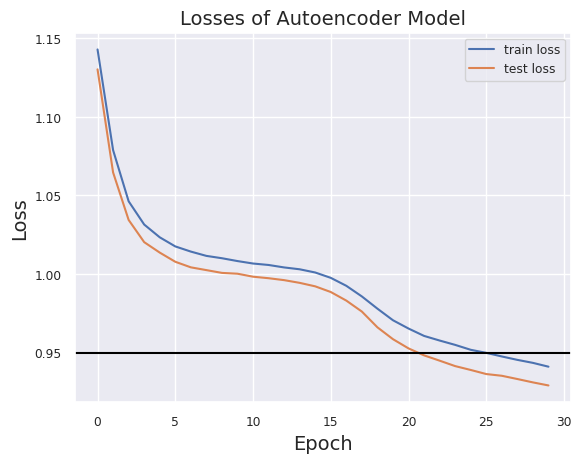

In [33]:
plt.plot(train_losses_all, label='train loss')
plt.plot(test_losses_all, label='test loss')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title("Losses of Autoencoder Model", fontsize=14)
plt.axhline(y = 0.95, color='black')
plt.legend();

## Use PCA and t-SNE on the dataset

Then use PCA on the latent space representation of the dataset.

Plot all of these.

### Obtain encoder latent space representation

In [34]:
### obtain encoder latent space
latent_model = model_all
X_tensor = torch.tensor(X).float()
latent_repre = latent_model.encoder(X_tensor)
latent_array = latent_repre.detach().numpy()

In [35]:
latent_array[:,0]

array([ 1.43280637e+00,  9.33292925e-01, -7.76552737e-01, -6.99364021e-02,
        3.10837603e+00, -5.98410606e-01,  8.59337211e-01, -3.77723277e-01,
        8.23791027e-01,  2.13553858e+00,  6.79239556e-02,  1.85255551e+00,
        5.05842734e-03,  2.51158738e+00,  3.85862529e-01, -3.15482616e-02,
       -5.66338122e-01,  4.86095399e-01, -2.02674285e-01, -1.03637385e+00,
        3.54025006e-01,  4.86665279e-01,  1.24795175e+00,  1.29921889e+00,
        7.57007658e-01,  8.05639982e-01, -7.76382610e-02, -1.70406580e-01,
       -2.64999539e-01, -1.43281683e-01, -2.99541414e-01, -4.26834255e-01,
        9.43588376e-01, -8.29021931e-01,  3.46069425e-01, -3.46689045e-01,
        1.52390516e+00, -4.11692113e-01, -9.49540436e-01, -3.46194953e-03,
        1.11737490e+00,  6.32763863e-01, -4.03758764e-01,  2.94615889e+00,
        1.17288724e-01,  1.11944115e+00, -8.82279873e-01,  1.90187246e-01,
        5.40710211e-01,  1.89709067e+00,  2.26848036e-01,  6.16136611e-01,
       -4.45153058e-01,  

### PCA

In [36]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)
print(X_pca, X_pca.shape)

[[-7.89467614  3.05552014]
 [-6.46938835  0.55003036]
 [ 5.21124272 -4.22127914]
 ...
 [-2.34543348 -7.00227644]
 [ 4.61173418  7.74244193]
 [-3.41509551 -1.60450232]] (700, 2)


In [37]:
pca_latent = PCA(n_components=2)
pca_latent.fit(latent_array)
X_pca_latent = pca_latent.transform(latent_array)

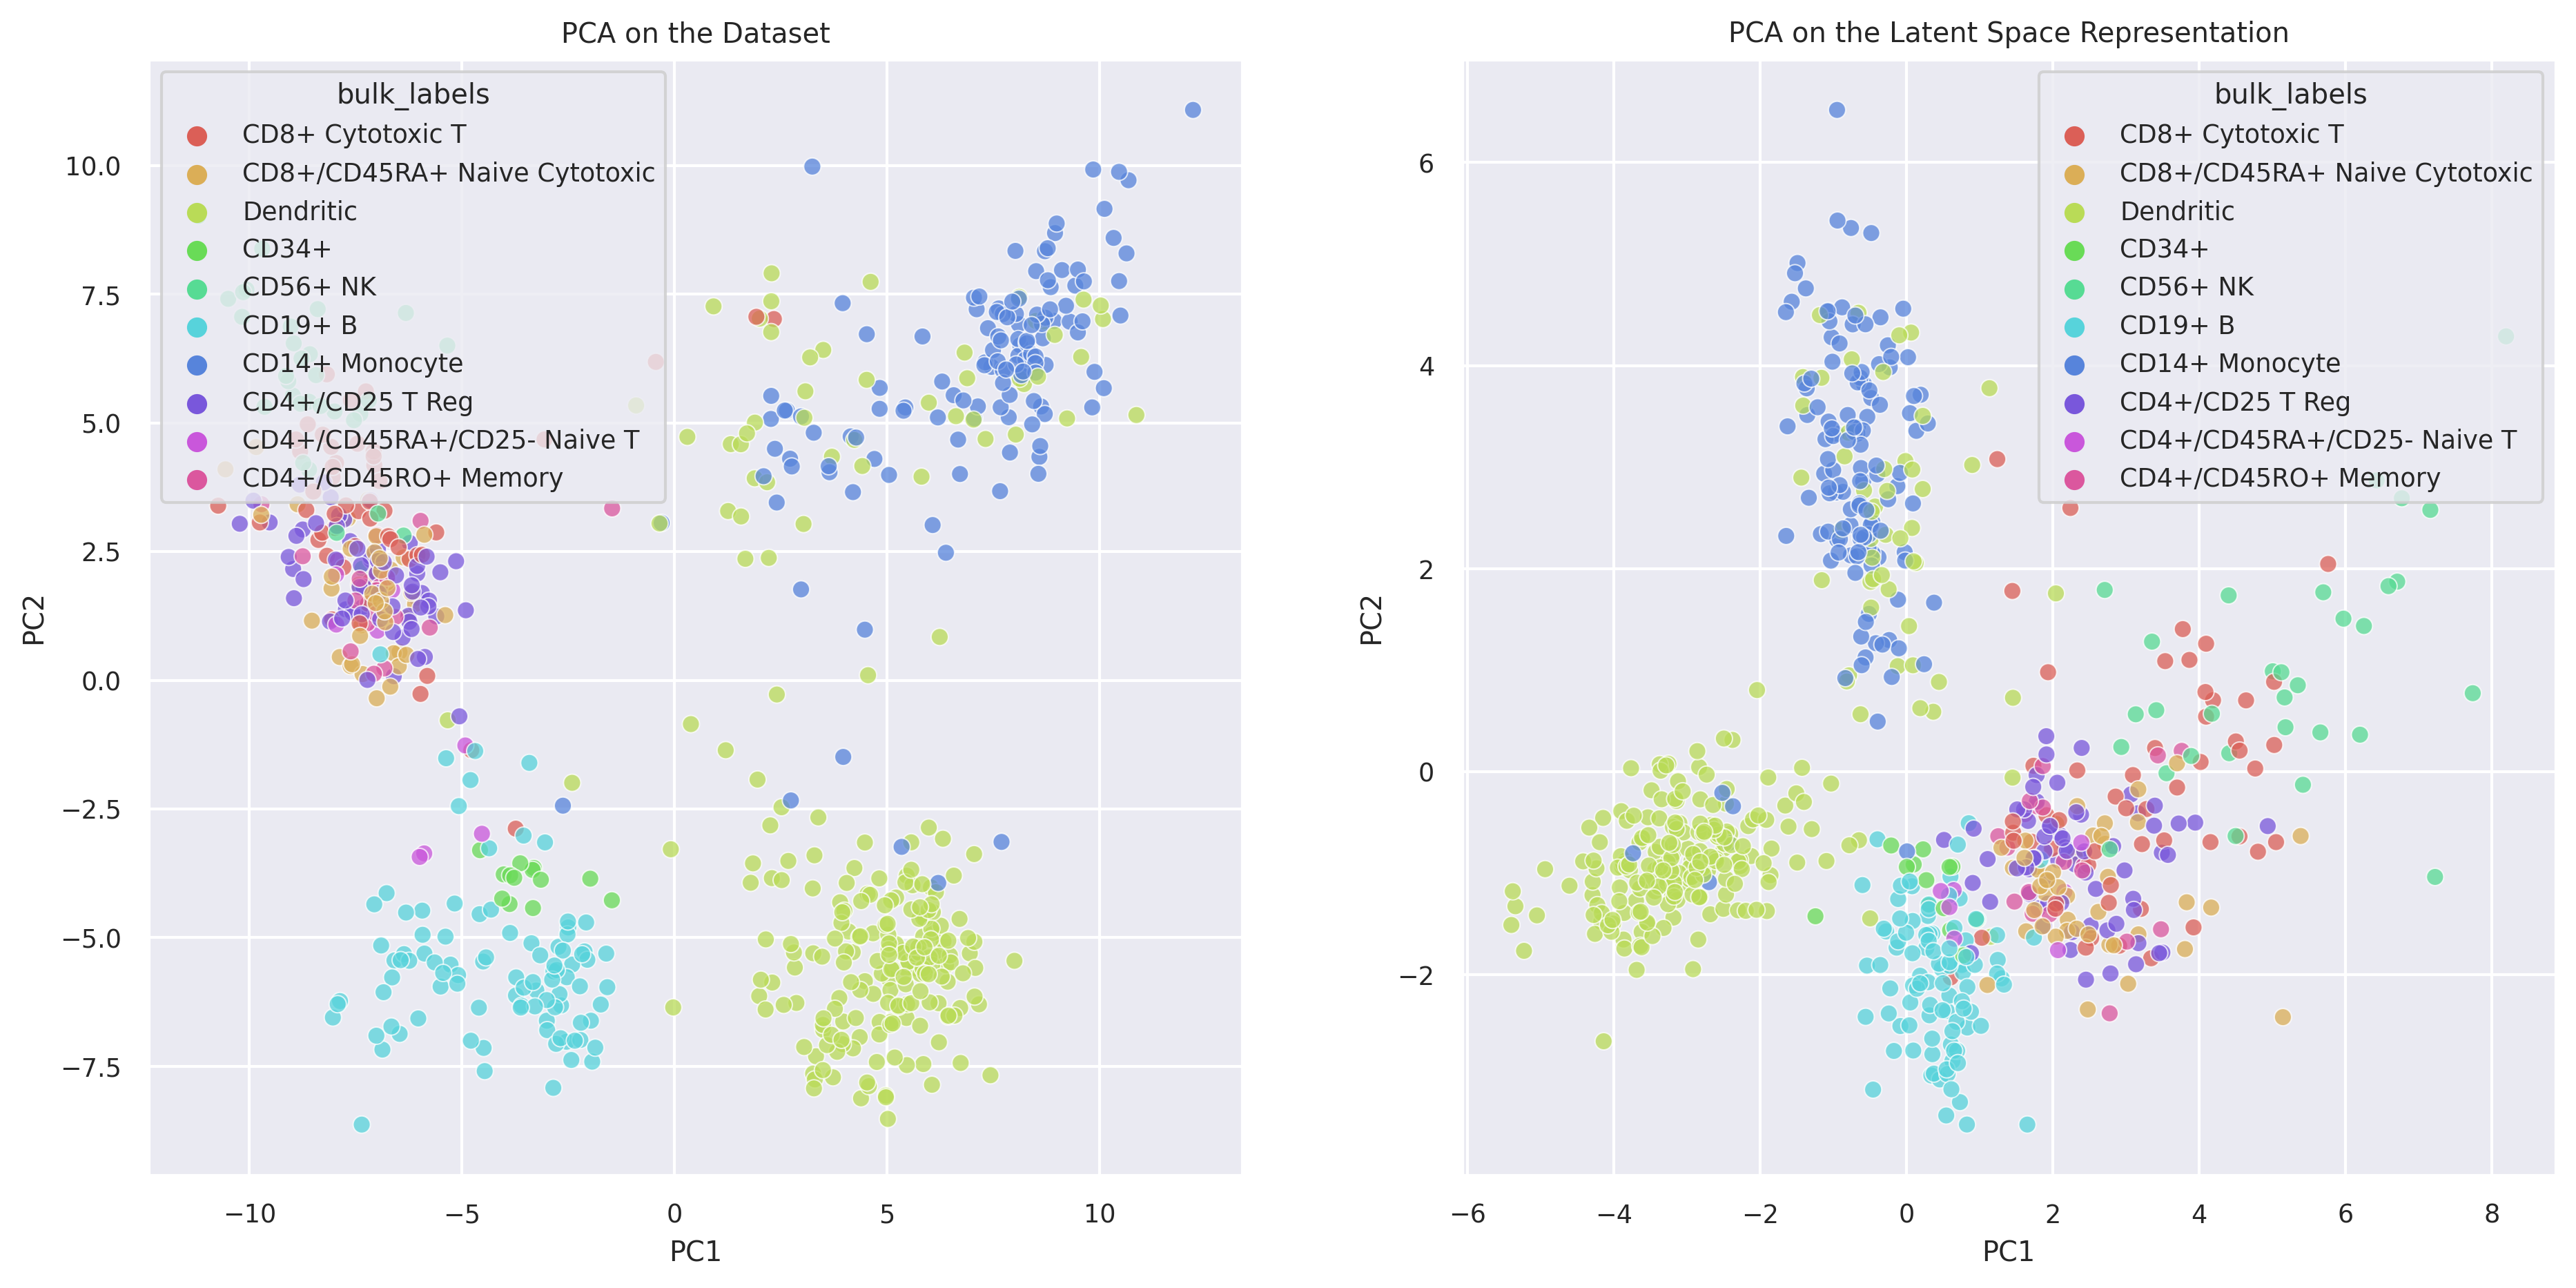

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7), dpi=300)
sns.set(font_scale=0.8)
# y for hue is the label data from previous, not y axis here
sns.scatterplot(
    x=X_pca[:,0], y=X_pca[:,1],
    hue=y, 
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.75,
    ax = axs[0])
axs[0].set_title("PCA on the Dataset")
axs[0].set_xlabel("PC1")
axs[0].set_ylabel("PC2")

sns.scatterplot(
    x=X_pca_latent[:,0], y=X_pca_latent[:,1],
    hue=y, 
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.75,
    ax = axs[1])
axs[1].set_title("PCA on the Latent Space Representation")
axs[1].set_xlabel("PC1")
axs[1].set_ylabel("PC2");

### tSNE

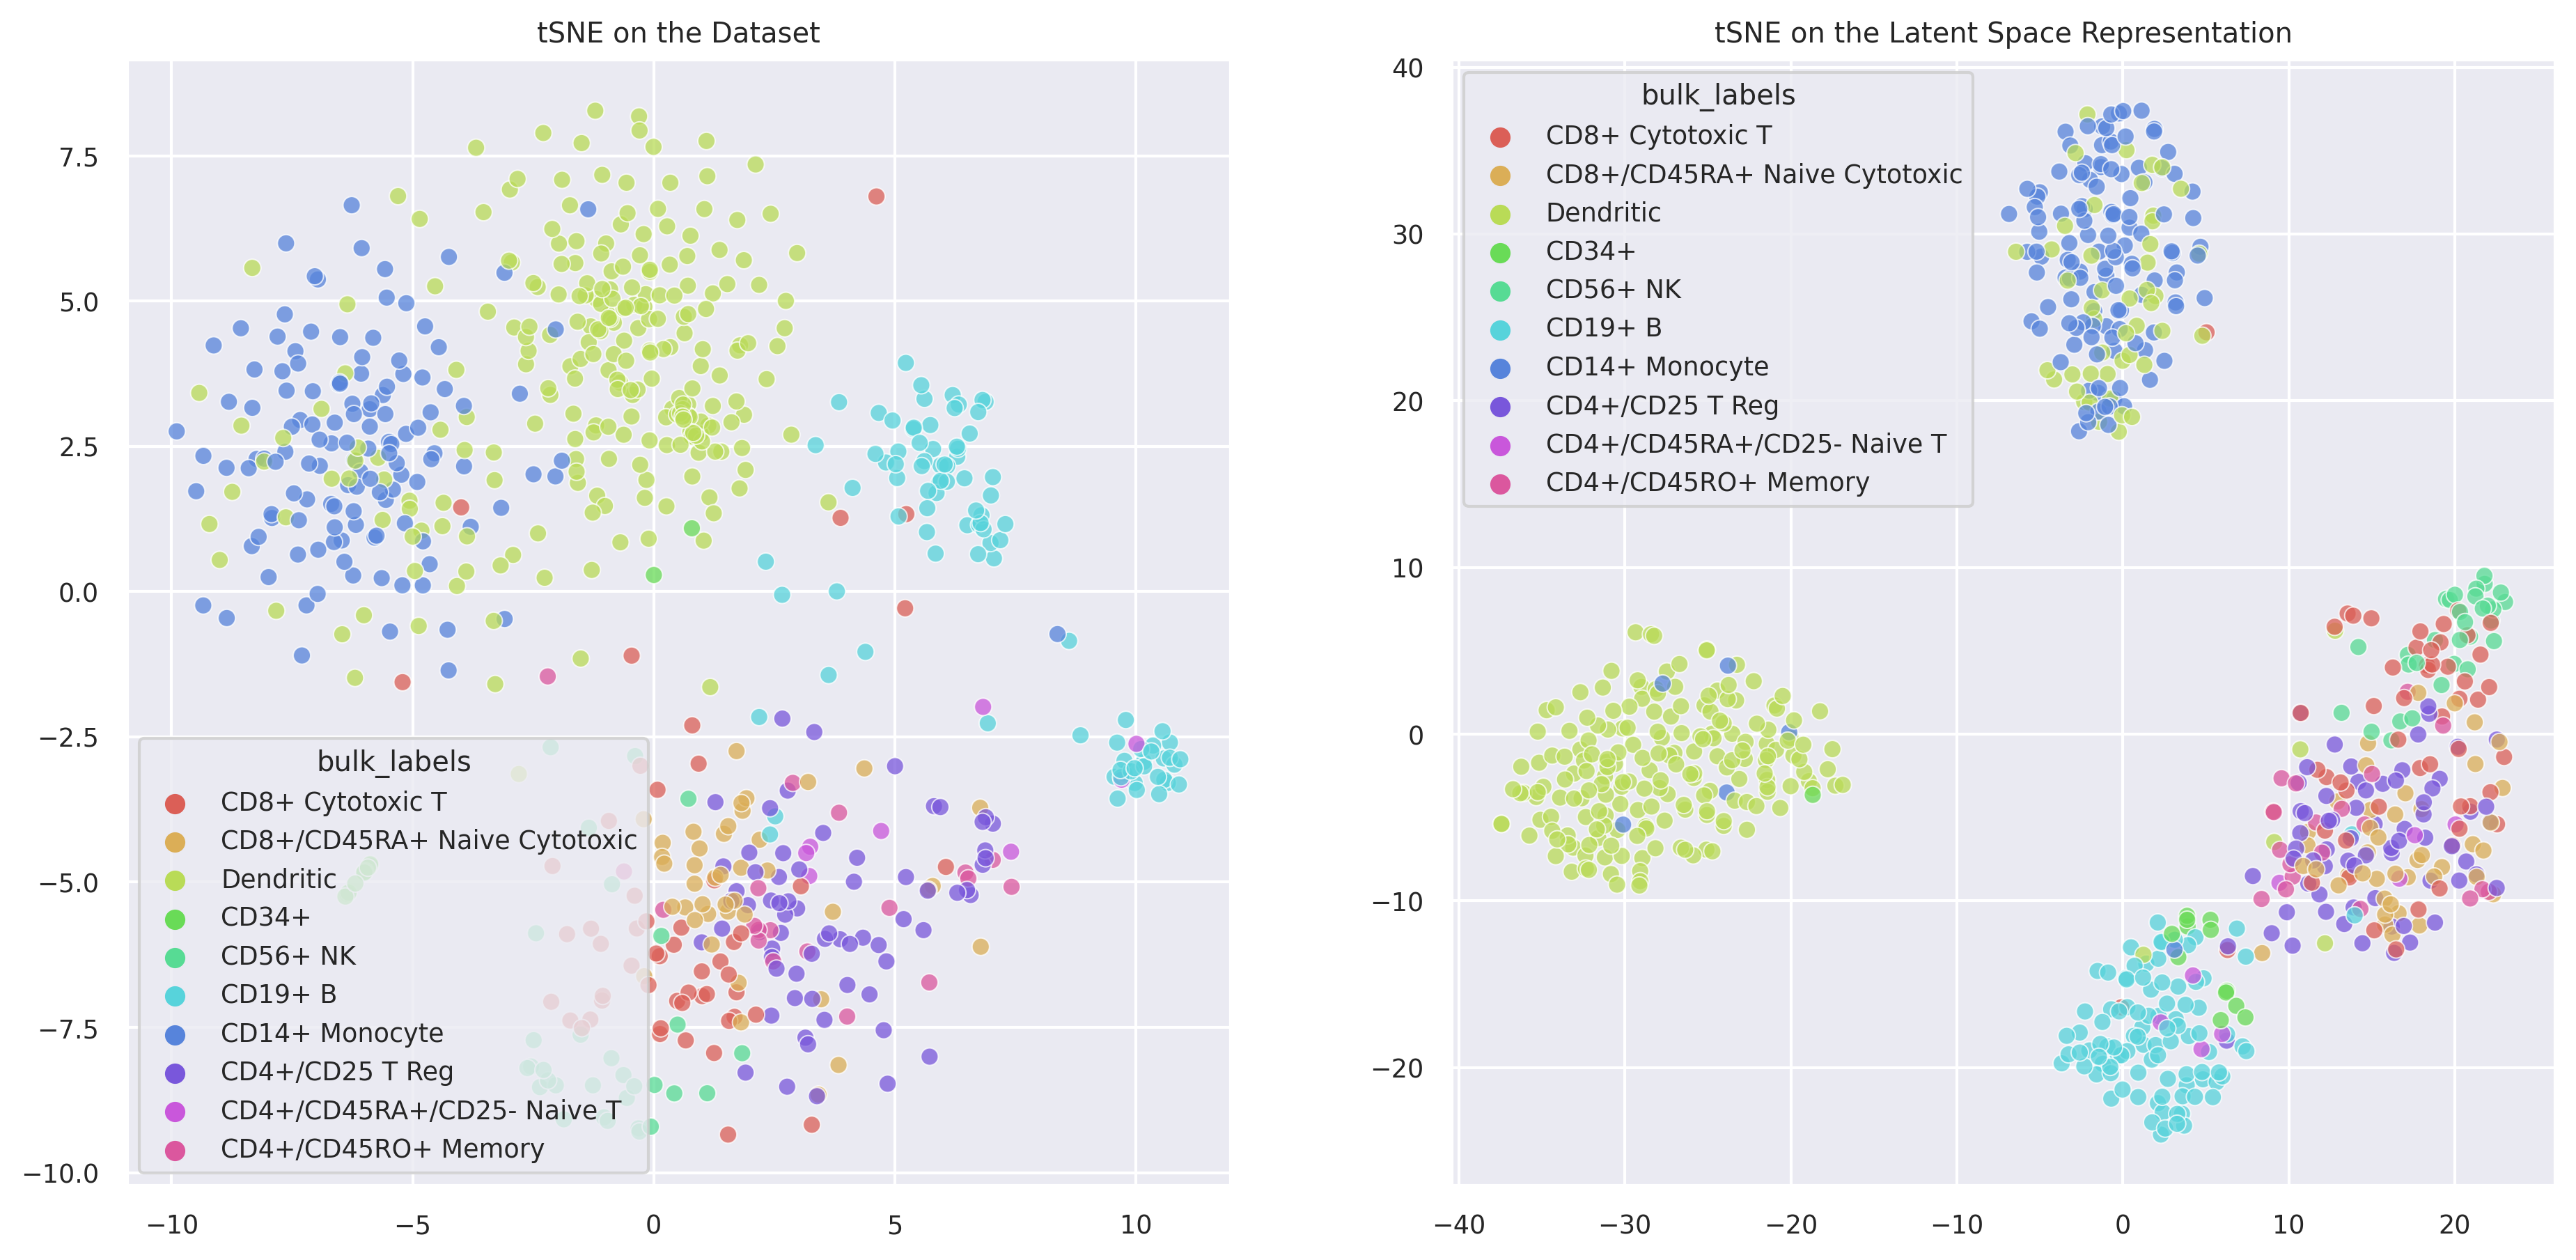

In [39]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
raw_tsne = tsne.fit_transform(X)

tsne_latent = TSNE(n_components=2)
la_tsne = tsne.fit_transform(latent_array)

fig, axs = plt.subplots(1, 2, figsize=(15, 7), dpi=300)
sns.set(font_scale=0.8)
# y for hue is the label data from previous, not y axis here
sns.scatterplot(
    x=raw_tsne[:,0], y=raw_tsne[:,1],
    hue=y, 
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.75,
    ax = axs[0])
axs[0].set_title("tSNE on the Dataset")

sns.scatterplot(
    x=la_tsne[:,0], y=la_tsne[:,1],
    hue=y, 
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.75,
    ax = axs[1])
axs[1].set_title("tSNE on the Latent Space Representation");

### Comparing the data

Compare the results of PCA, t-SNE, and your autoencoder as ways to visualize the data.

Text(0.5, 1.0, 'Random Two Genes of the Raw Data')

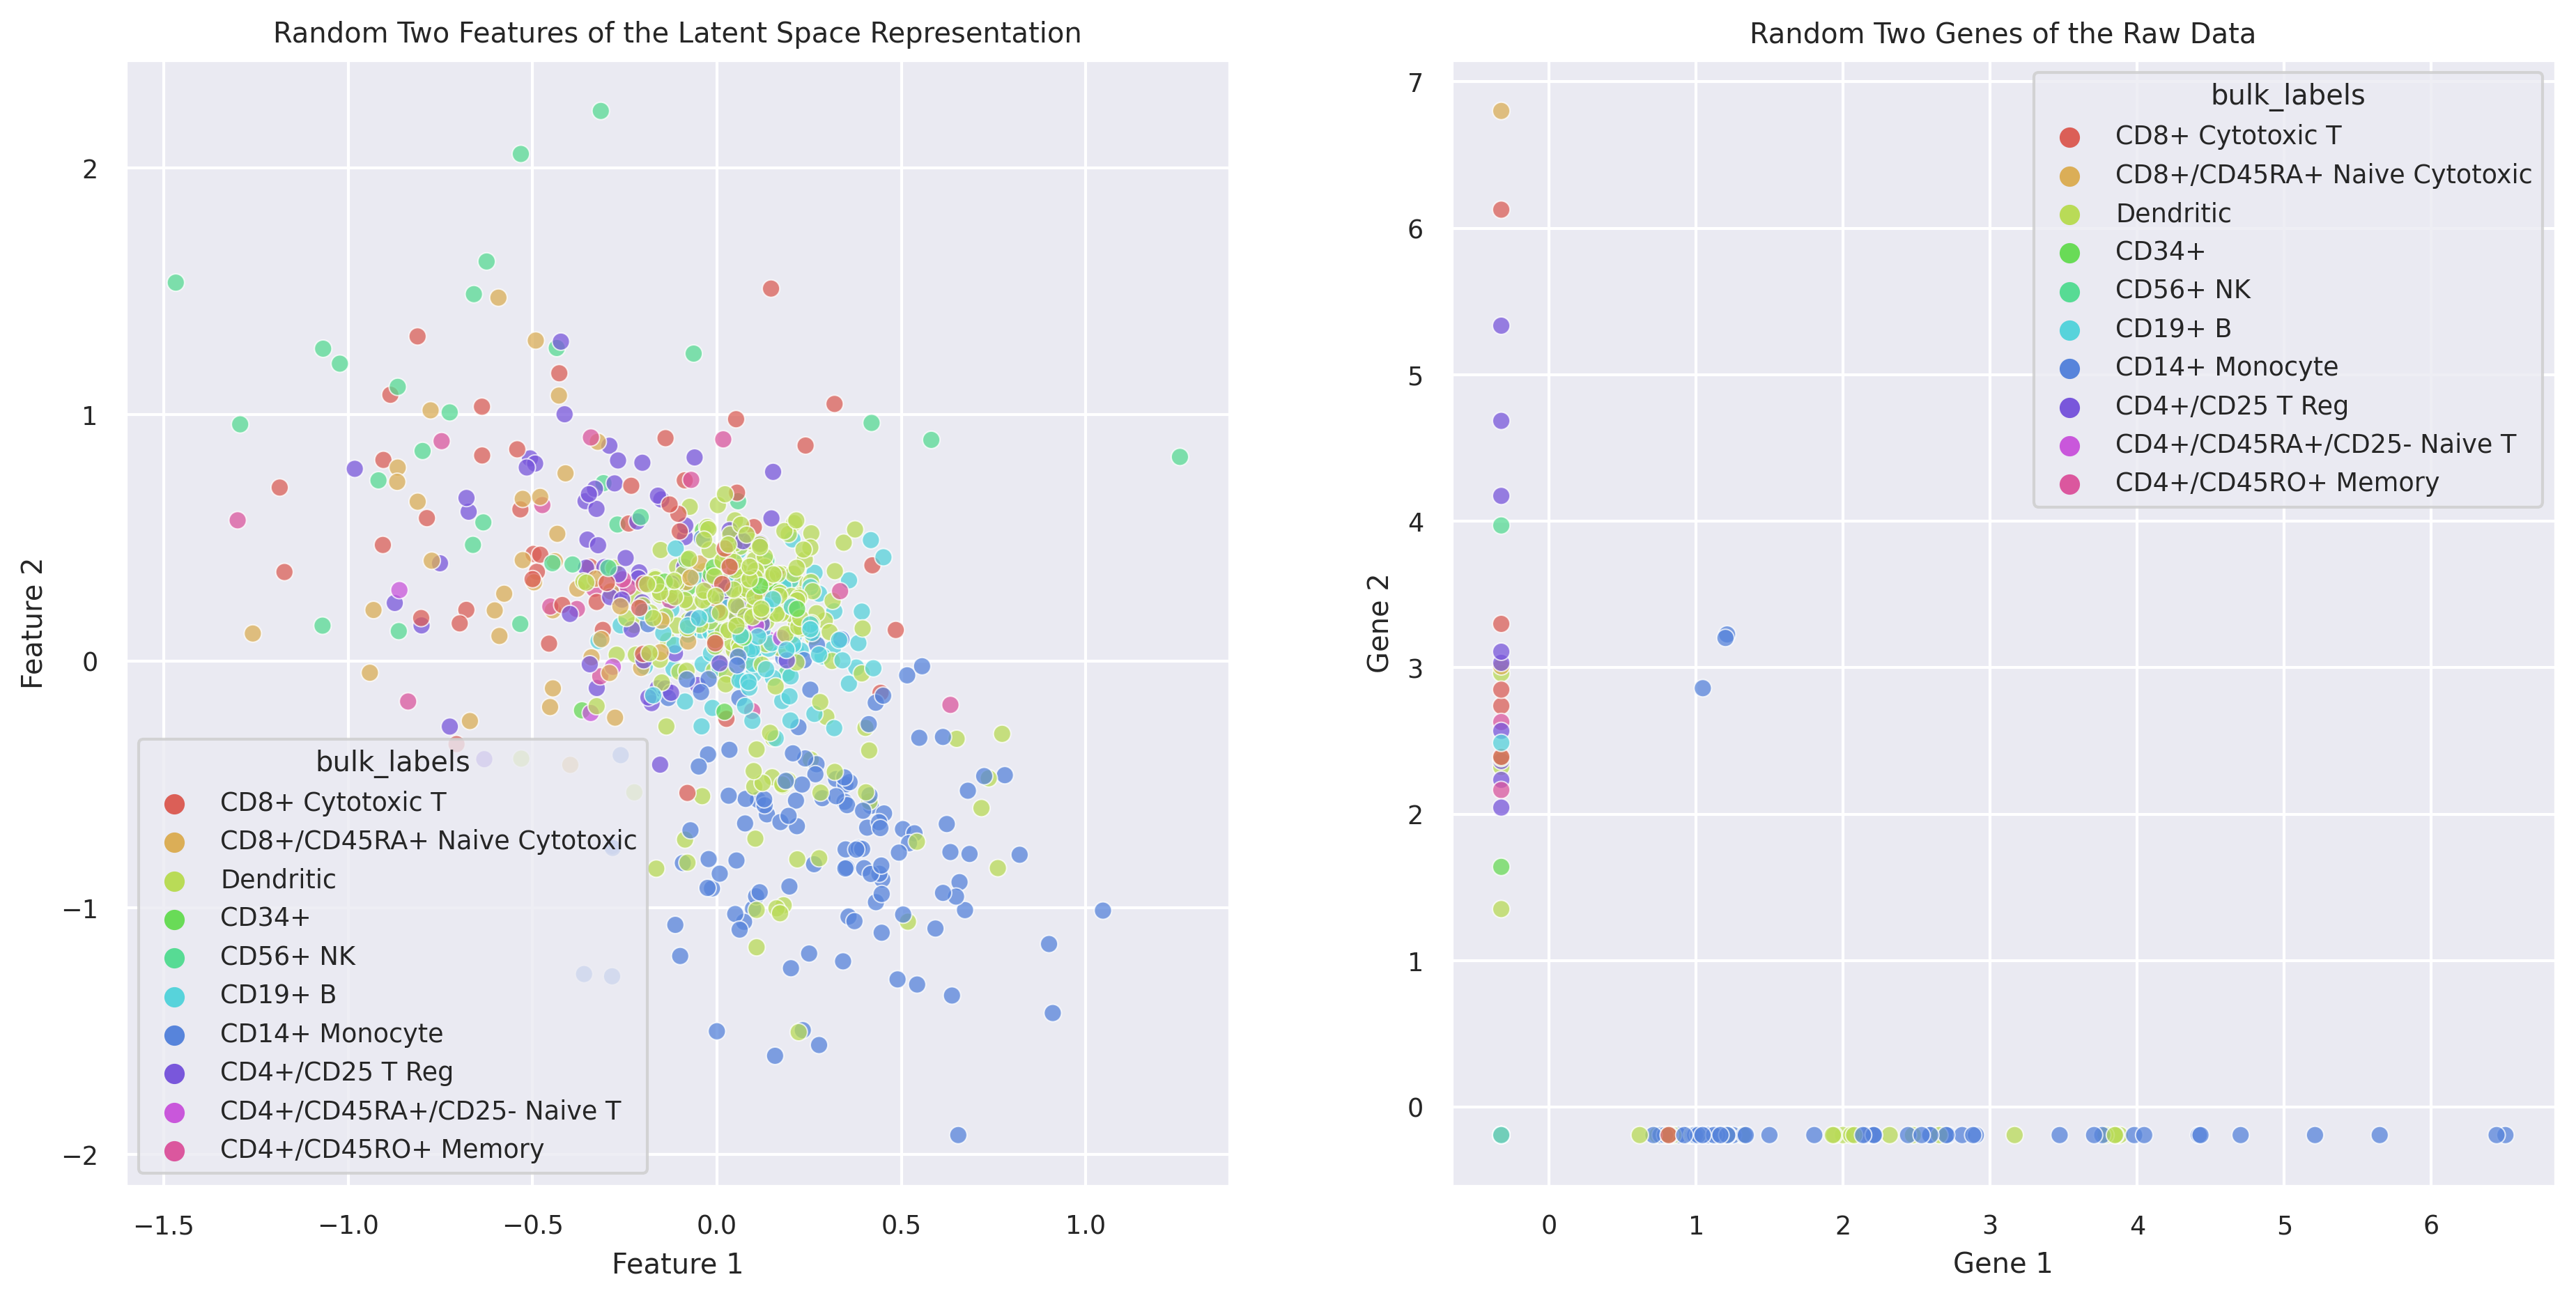

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7), dpi=300)
sns.set(font_scale=0.8)

sns.scatterplot(
    x=latent_array[:,0], y=latent_array[:,1],
    hue=y, 
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.75,
    ax = axs[0])
axs[0].set_xlabel('Feature 1')
axs[0].set_ylabel('Feature 2')
axs[0].set_title("Random Two Features of the Latent Space Representation")

sns.scatterplot(
    x=X[:,0], y=X[:,1],
    hue=y, 
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.75,
    ax = axs[1])
axs[1].set_xlabel('Gene 1')
axs[1].set_ylabel('Gene 2')
axs[1].set_title("Random Two Genes of the Raw Data")